# Ising Model with the Metropolis Algorithm

In the first section we will simulate the Ising model on a three-dimensional lattice of size $4 \times 4 \times 4$ (however, this simulation is designed to handle arbitrary dimensions with arbitrary side lengths), thus we have a total of $N = 64$ spins in our lattice. We wish to obtain some information about the average energy and the average magnetization, as well as the heat capacity and magnetic susceptibility which we can obtain via the relations:

$$C = \frac{\langle E^2 \rangle - \langle E \rangle^2}{k_B T^2} = \frac{\sigma_E^2}{k_B T^2}$$

$$\chi = \frac{\langle M^2 \rangle - \langle M \rangle^2}{k_B T} = \frac{\sigma_M^2}{k_B T}$$

Since we do not have the exact expectation values of the desired quantities we will use the average values obtained from the simulations instead to get an approximation.

For our simulations we will want to study their behavior for $\beta \in [0, 1]$, where $\beta = \frac{1}{k_B T}$.

In the second section we will visualize our results and analyze the plots to see if they make sense physically.

## Simulation

We now define our inital variables, with `L` being the dimensions of the lattice, and `τ` being the number of updates steps to perform in our Markov chain Monte Carlo simulations (more detailed explanation of `τ` below).

In [1]:
L = (4, 4, 4)
τ = 10^5
βs = range(0.001, stop=1, length=100);

Due to the memoryless nature of MCMC it is difficult to parallelize the simulation, but what we can do is run multiple simulations for different `β` values in parallel.

To do this we will use Julia's Distributed and DistributedArrays packages. `addprocs(n)` adds `n` processes. The `@everywhere` macro tells Julia to use those packages on all available threads. 

In [2]:
using Distributed; addprocs(7)
@everywhere using DistributedArrays
@everywhere using Random

To save computation time we'll create a function to store the nearest neighbors of each spin in a table `nn`, e.g. on a 2D square lattice this corresponds to the neighbors directly up, down, left, and right. This is an array of the same size and dimension as the lattice, where the $i$th entry of `nn` contains the indices of the nearest neighbors of the $i$th spin in the lattice. Thus when we want calculate the energy contribution from the $i$th spin we don't have to have to determine who its nearest neighbors are every time.

In [3]:
@everywhere function compute_nn(L::Tuple)
    nn = Array{Array{CartesianIndex, 1}}(undef, L) # creat nn array
    for index in CartesianIndices(nn) # loop over each site
        r = collect(Tuple(index)) # array of coordinates for current site
        nn_r = [] # create array for storing neighboring coordinates
        for i in 1:length(L) # determine neighbors in all dimensions
            r_ = copy(r)
            r[i] == L[i] ? r_[i] = 1 : r_[i] = r[i] + 1
            push!(nn_r, CartesianIndex(Tuple(r_)))
            r[i] == 1 ? r_[i] = L[i] : r_[i] = r[i] - 1
            push!(nn_r, CartesianIndex(Tuple(r_)))
        end
        nn[index] = nn_r # add neighbor coordinates array to nn array
    end
    return nn
end

nn = compute_nn(L);

We create a mutable structure called `Ising` to house all of the information from our simulation. To generate a new `Ising` structure all we need to do is call `Ising(L, β, nn)`.

In [4]:
@everywhere mutable struct Ising
    σ::Array{Int} # lattice of spins; array of integers of value ±1
    β::Float64 # = 1/(k_B * T)
    J::Float64 # coupling constant, we set = 1
    E_::Float64 # current energy
    E::Float64 # average energy
    E²::Float64 # average squared energy
    M_::Float64 # current energy
    M::Float64 # average magnetization
    M²::Float64 # average squared magnetization
    function Ising(L, β, nn; J=1.)
        σ = ones(Int, L) # initial spin configuration
        E₀ = 0 # calculate the initial energy
        for i in 1:length(σ)
            E₀ += σ[i] * sum([σ[j] for j in nn[i]])
        end
        E₀ = -J * E₀ / 2 # divide by 2 for doublecounting
        M₀ = sum(σ) # calculate initial magnetization
        new(σ, β, J, E₀, 0, 0, M₀, 0, 0) # create a new struct using the computed values
    end
end;

We define a function to update the running sum variables which we will call after every time step `t` in the update algorithm. We will later divide the sums by the number of measurements to get average values.

In [5]:
@everywhere function update_vars(x::Ising)
    x.E += x.E_; x.E² += x.E_^2
    x.M += abs(x.M_); x.M² += x.M_^2
end;

The last thing we need to do before simulating is implement the Metropolis algorithm. This is done in the function below which takes in `x` of type `Ising`, `τ` an integer number of update sweeps, and `nn` the precomputed nearest neighbors table. At each step `t` it will sweep through the lattice in sequential order and attempt to flip each spin. Optially we can pass the `cutoff` parameter (default value of $0.2$) which determines how much of the initial measurements we should discard, since we only desire measurements after thermalization; the optional `seed` parameter (default vaule of $8$) is the seed value for the random number generator so that we can get reproducible results. The output of the function is also an `Ising` type, but with the average values computed of the desired quantities.

In [6]:
@everywhere function Metropolis(x::Ising, τ::Int, nn::Array; cutoff::Float64=0.2, seed::Int=8)
    rng = MersenneTwister(seed) # initialize the random number generator
    t₀ = Int(cutoff * τ) # calculate step at which to start saving measurements
    for t in 1:τ # perform τ sweeps over the lattice
        for i in 1:length(x.σ) # attempt spin flips sequentially
            ΔE = 2 * x.J * x.σ[i] * sum([x.σ[j] for j in nn[i]]) # compute energy difference
            if ΔE < 0 || exp(-x.β * ΔE) > rand(rng) # check whether or not to flip spin
                x.σ[i] *= -1 # flip spin
                x.E_ += ΔE # update energy
                x.M_ += 2 * x.σ[i] # update magnetization
            end
        end
        t > t₀ ? update_vars(x) : continue # update variables if t > t₀
    end
    x.E /= (τ - t₀); x.E² /= (τ - t₀) # average out the quantites of interest
    x.M /= (τ - t₀); x.M² /= (τ - t₀)
    return x
end;

We now run the simulation and store the results in the variable `X`; a distributed array where each entry is an `Ising` type which has been simulated with a fixed `β` value.

In [7]:
X = @DArray [Metropolis(Ising(L, β, nn), τ, nn) for β in βs];

## Visualization and Analysis

Now that we have our data simulated let's visualize it. To do this we will leverage Julia's Plots library with the GR backend. We will look the average energy per spin `ε`, heat capacity per spin `cᵥ`, average absolute magnetization per spin `m`, and magnetic susceptibility per spin `χ`.

In [8]:
using DataFrames
using CSV
using Plots; gr()
using LaTeXStrings

Below we create a dataframe `df` and extract the desired information from the simulations into an easier to use format.

In [9]:
df = DataFrame(V=Int[], β=Float64[], E=Float64[], E²=Float64[], M=Float64[], M²=Float64[])
@simd for x in X
    push!(df, [length(x.σ), x.β, x.E, x.E², x.M, x.M²])
    end
df[:ε] = df[:E] ./ df[:V] # calculate energy per spin
df[:m] = df[:M] ./ df[:V] # calculate magnetization per spin
df[:cᵥ] = df[:β].^2 .* (df[:E²] .- df[:E].^2) ./ df[:V] # calculate heat capacity per spin
df[:χ] = df[:β] .* (df[:M²] .- df[:M].^2) ./ df[:V]; # calculate susceptibility per spin

We will also save the data to a .csv so we can re-load the it without having to run the simulation again.

In [10]:
df |> CSV.write("ising-metro-2D-L=4.csv"); # export from df to .csv

In [11]:
# df = CSV.read("ising-metro-3D-L=4.csv"); # import from .csv to df

In [12]:
ε_plot = plot(df[:β], df[:ε], xlabel=L"\beta", ylabel=L"\varepsilon(\beta)",
              legend=false, marker=:hexagon, markersize=2)
c_plot = plot(df[:β], df[:cᵥ], xlabel=L"\beta", ylabel=L"c_V(\beta)",
              legend=false, marker=:hexagon, markersize=2)
m_plot = plot(df[:β], df[:m], xlabel=L"\beta", ylabel=L"m(\beta)",
              legend=false, marker=:hexagon, markersize=2)
χ_plot = plot(df[:β], df[:χ], xlabel=L"\beta", ylabel=L"\chi(\beta)",
              legend=false, marker=:hexagon, markersize=2);

Below we plot the average energy and heat capacity per spin. We can se that for very low $\beta$ (high $T$) the energy is at its maximum of roughly zero, and decreases as $\beta$ increases ($T$ decreases). This makes sense with what we might think becauase at high temperatures we expect all of the spins to be anti-aligned and contribute the most to the energy whereas at low temperatures the spins all aligned contributing the least to the energy. The heat capacity can be seen to be roughly zero for very small $\beta$ due to the saturation effect (the system only has a finite number of energy states, thus at a certain point adding adding heat to the system will not increase the internal energy any more since there are no states with higher energy), and at higher $\beta$ we also observe a near zero heat capacity often seen in systems with an energy gap between the ground state and the first excited state.

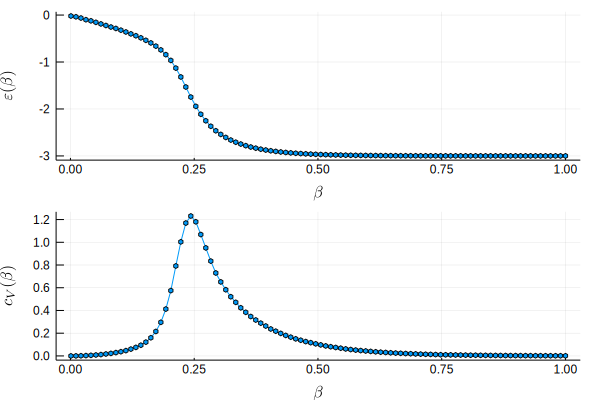

In [13]:
plot(ε_plot, c_plot, layout=(2, 1))

In the magnetization plot below we see what we might expect. For low $\beta$ we have no net magnetization because this is the high $T$ range where the spin pairs are in the maximum energy state of being anti-aligned. As $\beta$ increases we observe a phase transition to the magnetized state where the magnetization takes on a non-zero value. The susceptibility starts off at zero for $\beta = 0$, but increases until the phase transitions to the magnetized regime where it falls off to zero again. This makes sense because for high $T$ we wouldn't expect the system to be very susceptible to an external field, nor would we at very low temperatures.

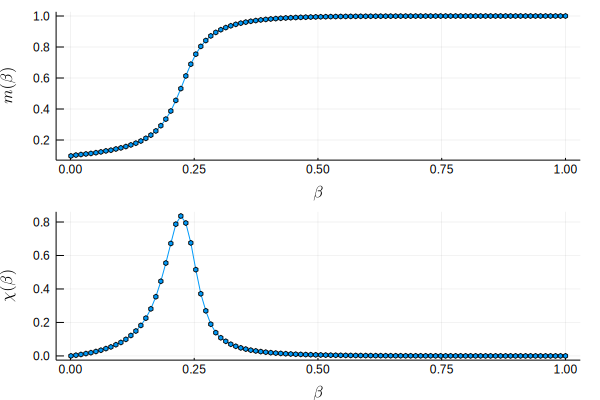

In [14]:
plot(m_plot, χ_plot, layout=(2, 1))